# Executing multiple parameters notebooks with papermill
___
**[Papermill](https://papermill.readthedocs.io/en/latest/)** is a Python library that allows you to parameterize, execute, and analyze Jupyter Notebooks, making it useful for automating and scaling data analysis workflows.

In this notebook, we will set up a routine that can generate trajectories for multiple fishes with adjusted parameters.
First we define important parameters that will be used in the loop that executes the notebooks.
The second part will generate ipynb files, based on a template noteboook, with the modified parameters, defined in the first cells of the notebook

### Parameters set up

In [ ]:
### Installations
!pip install "xarray-healpy @ git+https://github.com/iaocea/xarray-regridding.git@0ffca6058f4008f4f22f076e2d60787fcf32ac82"
!pip install -e ~/pangeo-fish/ 
### Copy the pangeo-fish notebook that we will submit to current directory
!cp ~/pangeo-fish/notebooks/pangeo-fish.ipynb .
#!pip install papermill copernicusmarine 

In [ ]:
# Necessary imports
import papermill as pm
import s3fs
import numpy as np
from datetime import datetime
import shutil
import os
from tqdm import tqdm
import pandas as pd
import pytz

In [ ]:
# Connecting to the bucket
s3 = s3fs.S3FileSystem(
    anon=False,
    client_kwargs={
        "endpoint_url": "https://s3.gra.perf.cloud.ovh.net",
    },
)

In [ ]:
### Parameters for the execution of the notebook

# Tags repo is the s3like path to the data stored on the bucket.
tags_repo = "gfts-ifremer/tags/bargip/clean_demo/"

# local_output is the path where the parametrized notebooks will be stored
local_output = "papermill_output"

# Indicate the name of notebook (needs to place it in the same direcotory) 
input_notebook = "pangeo-fish.ipynb"

# cloud_root is the path to acces the files on remote
cloud_root = "s3://gfts-ifremer/tags/bargip"

# folder name is the name of the folder where the result will be stored
folder_name = "tracks_test"

In [ ]:
# Setting up path for the s3 file access
tag_list = [tag.replace(tags_repo, "") for tag in s3.ls(tags_repo)]

In [ ]:
# Setting up parameters for the computation
remote = True

if remote:
    storage_options = {
        "anon": False,
        # 'profile' : "gfts",
        "client_kwargs": {
            "endpoint_url": "https://s3.gra.perf.cloud.ovh.net",
            "region_name": "gra",
        },
    }
    scratch_root = f"{cloud_root}/{folder_name}"

else:
    storage_options = None
    scratch_root = f"/home/jovyan/notebooks/papermill/{folder_name}"  # Update this path with your local path where you want to it to be stored

In [ ]:
# param is the dict passed as an argument to papermill
param = {"storage_options": storage_options, "scratch_root": scratch_root}

In [ ]:
# Verifying the params for the location
param

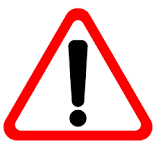

### BE CAREFUL FOR THE PATH CHOOSEN FOR **SCRATCH ROOT**, THIS PATH IS THE DIRECTORY WHERE THE RESULT OF THE COMPUTATION WILL BE STORED. WATCH OUT TO NOT OVERWRITE SOMETHING !

___
### Explantion of the code below 
- If the fish has observation over 2 days and has not been processed yet, it starts running a parametrized notebook.
- nbs is a list of the notebooks that has been processed, wether they failed or not. This list is used to keep a track of the tags that already has been generated.
These two conditions are used in the following way.
```
observation_length = (recapture_date - release_date) / np.timedelta64(1, "D")

if ((tag_name not in nbs) and observation_length > 2):  
```
First, it means that if the fish, based on the tagging events, has a observation period of less than two days, his trajectory will not be computed.
Second, It means that you can either choose to regenerate for all the tags that you generated once if you noticed that there was an issue in the results.
If the generation was interrupted during the process but the results are valid, you can start back you computation where it has stopped.

You might need to update this line of to switch from one behaviour to another, by removing 
```
(tag_name not in nbs) and
```
from this statement.
- The code loops over the tag id present in tag list and calculates the time difference in the tagging events.
- If it succeds, the generated notebook is placed papermill_output/done, else, it goes at papermill_output/failed
 

In [ ]:
%%time
timezone = pytz.timezone("Europe/Paris")
os.makedirs(f"{local_output}/done", exist_ok=True)
os.makedirs(f"{local_output}/failed", exist_ok=True)
nbs = []
nbs = [nb.replace(".ipynb", "") for nb in os.listdir(f"{local_output}/done")]
for fail in os.listdir(f"{local_output}/failed/"):
    nbs.append(fail.replace(".ipynb", ""))

for tag_name in tqdm(tag_list, desc="Processing tags"):
    print(tag_name)
    try:
        te = pd.read_csv(s3.open(f"{cloud_root}/cleaned/{tag_name}/tagging_events.csv"))
        release_date = np.datetime64(
            datetime.strptime(te["time"][0], "%Y-%m-%dT%H:%M:%SZ")
        )
        recapture_date = np.datetime64(
            datetime.strptime(te["time"][1], "%Y-%m-%dT%H:%M:%SZ")
        )
        observation_length = (recapture_date - release_date) / np.timedelta64(1, "D")
        print(observation_length)

        if (tag_name not in nbs) and observation_length > 2:
            print(tag_name)
            print(datetime.now(timezone).strftime("%Y-%m-%d %H:%M:%S"))
            param["tag_name"] = tag_name
            output_path = f"{local_output}/{tag_name}.ipynb"
            destination_path = f"{local_output}/done/{tag_name}.ipynb"
            pm.execute_notebook(
                input_path=input_notebook, output_path=output_path, parameters=param
            )
            shutil.move(output_path, destination_path)
    except Exception:
        print(f"Error for {tag_name}")
        destination_path = f"{local_output}/failed/{tag_name}.ipynb"
        shutil.move(output_path, destination_path)